In [1]:
# Import modules
import pandas as pd
import scanpy as sc
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import scipy.sparse as sp
from tqdm.auto import tqdm
from scipy.stats.contingency import crosstab
import seaborn as sns
import matplotlib.pyplot as plt

/home/inf-39-2024/.conda/envs/scseq/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load the datasets
path_file = '8_Classifiers/Data/Input/adata_myeloid.h5ad'

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 182934 × 10
    obs: 'UMAP1', 'UMAP2', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'cell_type', 'louvain_None', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'myeloid_cell_type', 'myeloid_louvain_None', 'myeloid_louvain_0.4', 'myeloid_louvain_0.6', 'myeloid_louvain_1.0', 'myeloid_louvain_1.4', 'myeloid_louvain_1.6', 'myeloid_louvain_1.8', 'myeloid_louvain_2.0', 'myeloid_louvain_1.2', 'predicted_type_1.0', 'predicted_type_1.2', 'predicted_type_1.4', 'predicted_type_1.6', 'predicted_type_1.8', 'predicted_type_2.0'
    var: 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'louvain_None', 'myeloid_cell_type_colors', 'myeloid_louvain_0.4', 'myeloid_louvain_0.4_colors', 'myeloid_louvain_0.6', 'myeloid_louvain_0.6_colors',

In [11]:
# Set X and Y
X = adata.X
Y = adata.obs['myeloid_cell_type']

In [6]:
# Split into traiing and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y, random_state=42)

In [ ]:
# Create an array of indices for all cells
all_indices = np.arange(X.shape[0])

# Split indices, keeping track of which are train/test
train_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.1,
    stratify=Y,
    random_state=42)

# Use indices to subset X and Y
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = Y[train_idx], Y[test_idx]

/tmp/ipykernel_3744188/1870435252.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_train, Y_test = Y[train_idx], Y[test_idx]


In [4]:
adata.obs['myeloid_cell_type'].unique()

['Macrophages', 'Rest', 'Neutrophils', 'DCs', 'Monocytes', 'Mast Cells']
Categories (6, object): ['DCs', 'Macrophages', 'Mast Cells', 'Monocytes', 'Neutrophils', 'Rest']

In [ ]:
print('Original class distribution:\n', pd.Series(Y).value_counts(normalize=True))
print('\nTraining class distribution:\n', pd.Series(Y_train).value_counts(normalize=True))
print('\nTraining class counts:\n', pd.Series(Y_train).value_counts())

Original class distribution:
 myeloid_cell_type
Macrophages    0.880301
Monocytes      0.064083
Rest           0.029978
Neutrophils    0.018652
DCs            0.006937
Mast Cells     0.000049
Name: proportion, dtype: float64

Training class distribution:
 myeloid_cell_type
Macrophages    0.880302
Monocytes      0.064085
Rest           0.029974
Neutrophils    0.018653
DCs            0.006936
Mast Cells     0.000049
Name: proportion, dtype: float64

Training class counts:
 myeloid_cell_type
Macrophages    144933
Monocytes       10551
Rest             4935
Neutrophils      3071
DCs              1142
Mast Cells          8
Name: count, dtype: int64


In [ ]:
# Train the random forest classifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
clf = RandomForestClassifier(max_features='sqrt', bootstrap=True, oob_score=True, n_jobs=1, random_state=42)

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=inner_cv,
    n_jobs=-1)

grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_

Y_pred = best_model.predict(X_test)
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='weighted')

print(f"\nBest Params: {grid_search.best_params_}")
print(f"Accuracy on test set: {acc:.3f}")
print(f"F1 score on test set: {f1:.3f}")
print('\nClassification Report:\n', classification_report(Y_test, Y_pred))

joblib.dump(best_model, '8_Classifiers/Models/best_rf_model.pkl')



Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy on test set: 0.999
F1 score on test set: 0.999

Classification Report:
               precision    recall  f1-score   support

         DCs       0.98      0.98      0.98       127
 Macrophages       1.00      1.00      1.00     16104
  Mast Cells       1.00      1.00      1.00         1
   Monocytes       0.99      0.99      0.99      1172
 Neutrophils       0.99      1.00      1.00       341
        Rest       0.99      0.98      0.99       549

    accuracy                           1.00     18294
   macro avg       0.99      0.99      0.99     18294
weighted avg       1.00      1.00      1.00     18294



['../TestClassifiers/best_rf_classifier.pkl']

In [ ]:
clf = joblib.load('8_Classifiers/Models/best_rf_model.pkl')

In [14]:
# Predict
Y_pred = clf.predict(X_test)

In [15]:
Y_pred = clf.predict(X[test_idx])
Y_test = Y[test_idx]

/tmp/ipykernel_3744188/877887143.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_test = Y[test_idx]


In [16]:
# Get obs_names (row labels) for test set
test_obs_names = adata.obs_names[test_idx]

# Assign NaNs first
adata.obs['rf_predicted_cell_type'] = np.nan

# Now assign predictions using aligned obs_names
adata.obs.loc[test_obs_names, 'rf_predicted_cell_type'] = Y_pred

/tmp/ipykernel_3744188/3327339340.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Macrophages' 'Macrophages' 'Macrophages' ... 'Macrophages' 'DCs'
 'Macrophages']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[test_obs_names, 'rf_predicted_cell_type'] = Y_pred


In [ ]:
acc = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='weighted')

print(f"Accuracy on test set: {acc:.3f}")
print(f"F1 score on test set: {f1:.3f}")
print('\nClassification Report:\n', classification_report(Y_test, Y_pred))

Accuracy on test set: 0.999
F1 score on test set: 0.999

Classification Report:
               precision    recall  f1-score   support

         DCs       0.98      0.98      0.98       127
 Macrophages       1.00      1.00      1.00     16104
  Mast Cells       1.00      1.00      1.00         1
   Monocytes       0.99      0.99      0.99      1172
 Neutrophils       0.99      1.00      1.00       341
        Rest       0.99      0.98      0.99       549

    accuracy                           1.00     18294
   macro avg       0.99      0.99      0.99     18294
weighted avg       1.00      1.00      1.00     18294



In [ ]:
adata.write_h5ad('8_Classifiers/Data/Input/pred_adata_myeloid_.h5ad')

In [ ]:
# Load the datasets
path_file = '8_Classifiers/Data/Input/pred_adata_myeloid_.h5ad'

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 182934 × 10
    obs: 'UMAP1', 'UMAP2', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'cell_type', 'louvain_None', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'myeloid_cell_type', 'myeloid_louvain_None', 'myeloid_louvain_0.4', 'myeloid_louvain_0.6', 'myeloid_louvain_1.0', 'myeloid_louvain_1.4', 'myeloid_louvain_1.6', 'myeloid_louvain_1.8', 'myeloid_louvain_2.0', 'myeloid_louvain_1.2', 'predicted_type_1.0', 'predicted_type_1.2', 'predicted_type_1.4', 'predicted_type_1.6', 'predicted_type_1.8', 'predicted_type_2.0', 'lr_predicted_cell_type'
    var: 'gene_id', 'gene_name'
    uns: 'cell_type_colors', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'louvain_0.4', 'louvain_0.6', 'louvain_1.0', 'louvain_1.4', 'louvain_None', 'myeloid_cell_type_colors', 'myeloid_louvain_0.4', 'myeloid_louvain_0.4_colors', 'myeloid_louvain_0.6', 'my

In [4]:
# Plot the results with only the predicted cell types and not the NaNs
# Select only rows where prediction is not NaN
mask = adata.obs['rf_predicted_cell_type'].notna()

# Extract true and predicted labels for test cells
true_labels = adata.obs.loc[mask, 'myeloid_cell_type']
pred_labels = adata.obs.loc[mask, 'rf_predicted_cell_type']



In [24]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[  125     0     0     1     0     1]
 [    0 16099     0     3     0     2]
 [    0     0     1     0     0     0]
 [    1     3     0  1164     0     4]
 [    0     0     0     0   341     0]
 [    1     3     0     3     2   540]]
              precision    recall  f1-score   support

         DCs       0.98      0.98      0.98       127
 Macrophages       1.00      1.00      1.00     16104
  Mast Cells       1.00      1.00      1.00         1
   Monocytes       0.99      0.99      0.99      1172
 Neutrophils       0.99      1.00      1.00       341
        Rest       0.99      0.98      0.99       549

    accuracy                           1.00     18294
   macro avg       0.99      0.99      0.99     18294
weighted avg       1.00      1.00      1.00     18294



<Axes: >

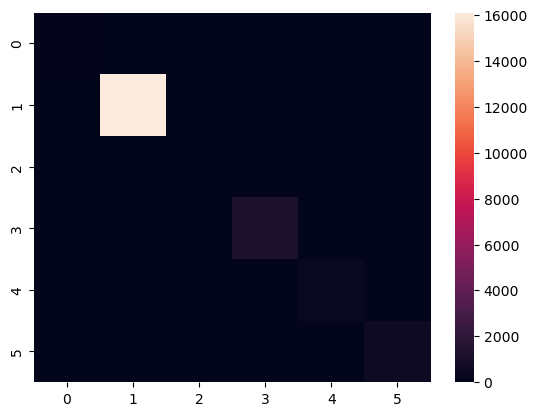

In [27]:
sns.heatmap(crosstab(list(true_labels.values), list(pred_labels.values)).count)

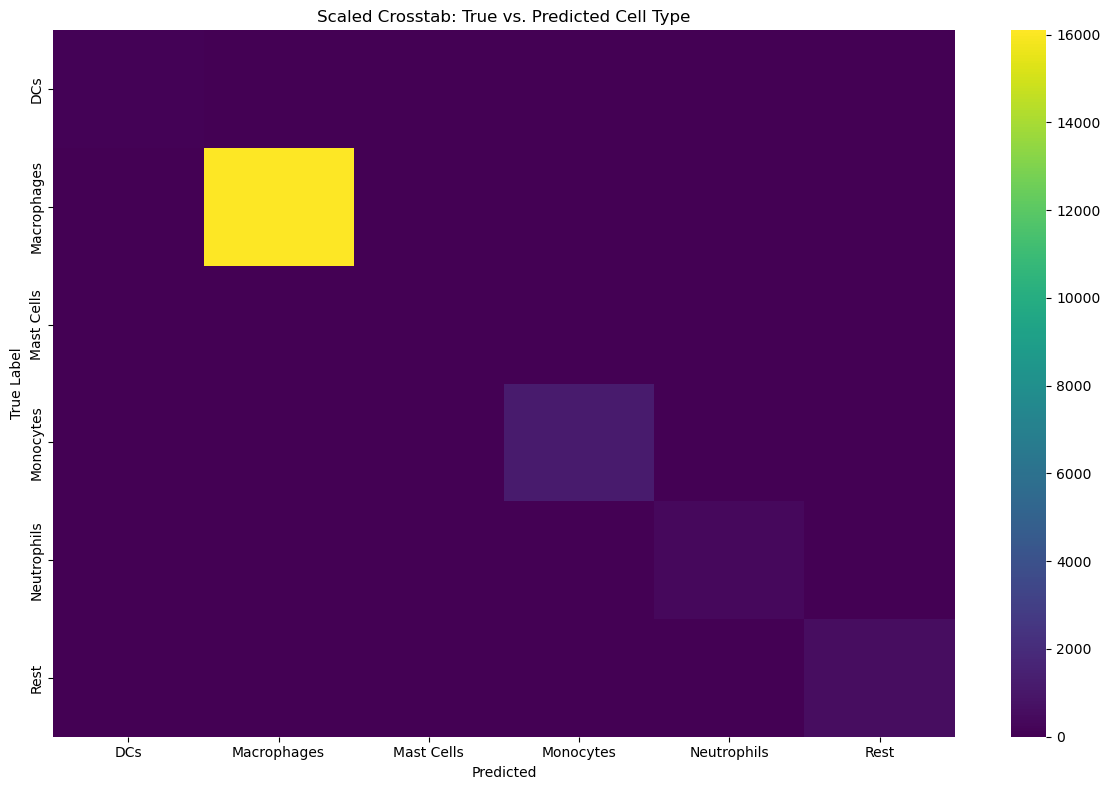

In [ ]:
# Create the crosstab
ct = pd.crosstab(true_labels, pred_labels)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ct, cmap='viridis', fmt='.0f')
plt.title('Scaled Crosstab: True vs. Predicted Cell Type')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

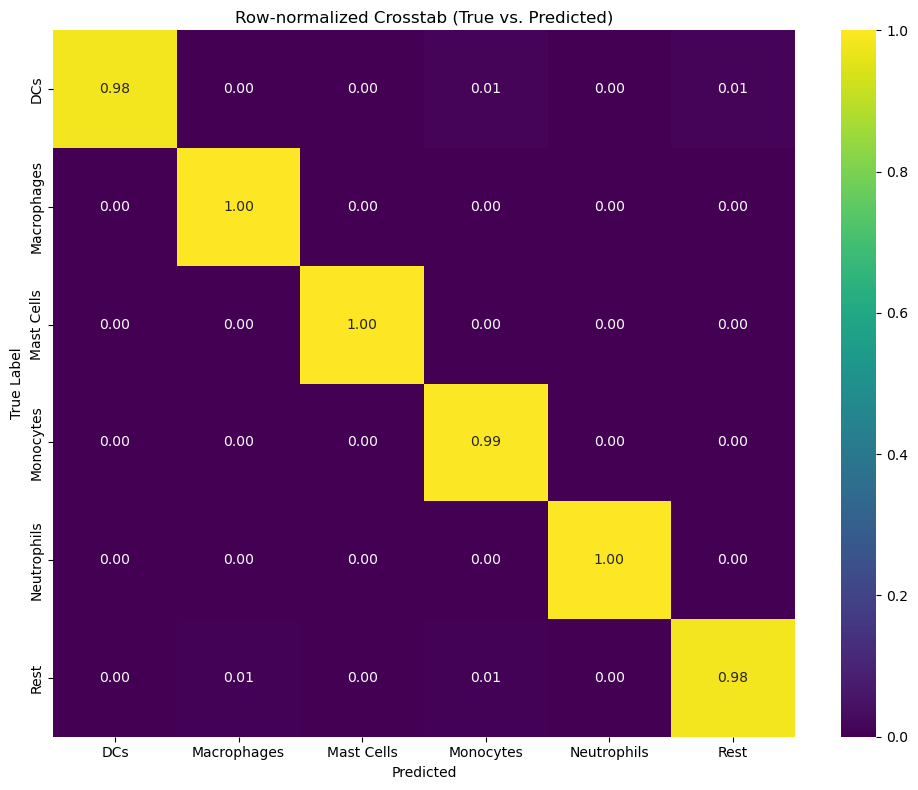

In [ ]:
# Row normalize the true labels to show the performance of classification for each class
ct_normalized = pd.crosstab(true_labels, pred_labels, normalize='index')

plt.figure(figsize=(10, 8))
sns.heatmap(ct_normalized, cmap='viridis', annot=True, fmt='.2f')
plt.title('Row-normalized Crosstab (True vs. Predicted)')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()